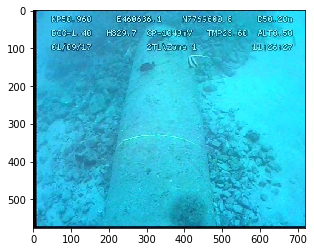

In [1]:
#filename='img18007.jpg'
filename='test.jpg'
import mxnet as mx
from mxnet import image
from gluoncv.data.transforms.presets.segmentation import test_transform
import gluoncv
from matplotlib import pyplot as plt
import cv2
import numpy as np

img = image.imread(filename)
plt.imshow(img.asnumpy())
plt.show()

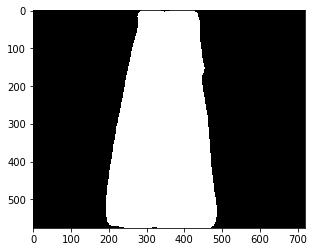

In [2]:
# use cpu
ctx = mx.cpu(0)

## load test image
img = image.imread(filename)
img = test_transform(img, ctx)
img = img.astype('float32')


# reconstruct the PSP network model
#model = gluoncv.model_zoo.DeepLabV3(nclass=2, backbone='resnet101')
model = gluoncv.model_zoo.DeepLabV3(nclass=2, backbone='resnet50')

# load the trained model

model.load_parameters('model/model_algo-1', ctx=ctx , ignore_extra=True)
#print(model.summary)

# make inference

output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
plt.imshow(predict, cmap='gray')

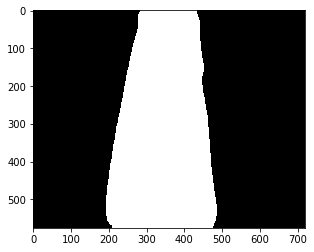

In [3]:
#predict = cv2.imdecode(predict, flags=0)
predict = predict.astype(np.uint8)
dst = cv2.fastNlMeansDenoising(predict,None,10,7,21)

plt.imshow(dst, cmap='gray')

(576, 720, 3)


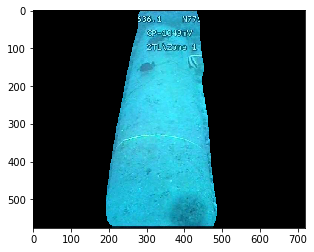

In [4]:
img1 = cv2.imread(filename)
plt.imshow(img1)

ret, mask = cv2.threshold(dst, .5, 255, cv2.THRESH_BINARY)

white_background = np.full(img1.shape, 255, dtype=np.uint8)
bk = cv2.bitwise_or(white_background, white_background, mask=mask)

final = cv2.bitwise_and(img1, bk)

plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
print(final.shape)

#cv2.imshow("g", final)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

343 318


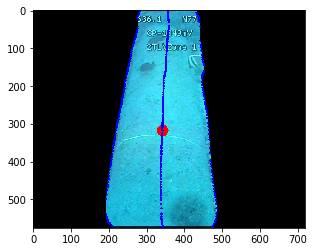

In [5]:
import numpy as np
import cv2


def skeletonize(image):
    img = image.copy()
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    done = False

    #img =cv2.bitwise_not(img)
    original = img

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True

    return skel, cv2.dilate(skel, element)


def collapse_contours(contours):
    contours = np.vstack(contours)
    contours = contours.squeeze()
    return contours


def get_rough_contour(image):
    """Return rough contour of character.
    image: Grayscale image.
    """
    img = image.copy()
    im2, contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = collapse_contours(contours)
    return contour


def draw_contour(image, contour, colors=(255, 0, 0)):
    for p in contour:
        cv2.circle(image, tuple(p), 1, colors, 2)

contourMask  = get_rough_contour(mask)
M = cv2.moments(contourMask)
if (M['m00'] != 0):
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    print(cx, cy)
    cv2.circle(final, (cx,cy), 0,(0,0,255), 30)

skeleton, dskeleton = skeletonize(mask)
contourSkeleton  = get_rough_contour(skeleton)
draw_contour(final, contourSkeleton)


draw_contour(final, contourMask)

plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

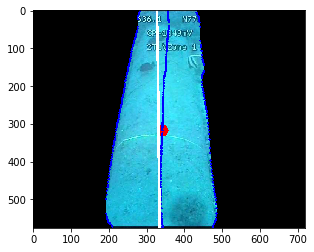

In [6]:
cnt = contourMask.copy()
rows,cols = mask.shape[:2]
[vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
lefty = int((-x*vy/vx) + y)
righty = int(((cols-x)*vy/vx)+y)
img = cv2.line(final,(cols-1,righty),(0,lefty),(255,255,255),5)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
#cnt = contourMask.copy()

img = mask.copy()
im2, contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = collapse_contours(contours)
cnt = contour.copy()

#ma = cv2.minAreaRect(cnt);
#bp= cv2.boxPoints(ma)
#print(bp)

#print(cnt[cnt[:,:].argmin()])
#print(cnt[cnt[:,:].argmin()])
leftmost = tuple(cnt[cnt[:, 0].argmin()])
rightmost = tuple(cnt[cnt[:,0].argmax()])
topmost = tuple(cnt[cnt[:,1].argmin()])
bottommost = tuple(cnt[cnt[:,1].argmax()])
print(leftmost)
print(rightmost)
print(topmost)
print(bottommost)
cv2.circle(final, leftmost, 0,(0,255,255), 30)
cv2.circle(final, rightmost, 0,(0,255,255), 30)
cv2.circle(final, topmost, 0,(0,255,255), 30)
cv2.circle(final, bottommost, 0,(0,255,255), 30)

plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))